<a href="https://colab.research.google.com/github/Sherlock-221BBS/vision_transformer/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 34.08 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
   batch_size = BATCH_SIZE
)

(-0.5, 223.5, 223.5, -0.5)

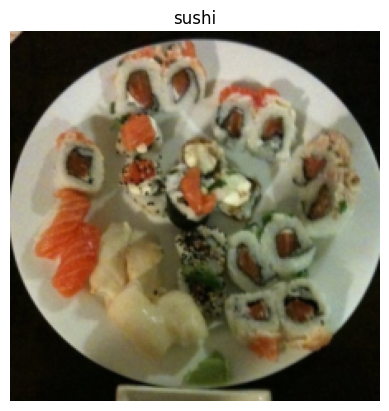

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[10], label_batch[10]

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')


In [9]:
image.shape

torch.Size([3, 224, 224])

## 1. Split the image into patches and create class, patch, position embedding

In [10]:
image_height = 224
image_width = 224
color_channels = 3


patch_size = 16
number_of_patches = int((image_height * image_width)/patch_size ** 2)
embedding_layer_input_shape = (image_height, image_width)
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

print(f"Embedding Layer input shape: {embedding_layer_input_shape}")
print(f"Embedding Layer output shape: {embedding_layer_output_shape}")

Embedding Layer input shape: (224, 224)
Embedding Layer output shape: (196, 768)


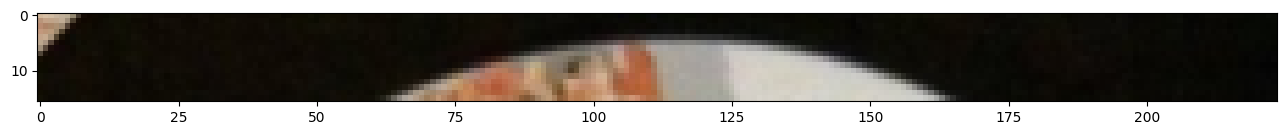

In [11]:
image_permuted = image.permute(1, 2, 0)
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Patch Size: 16 pixels x 16 pixels



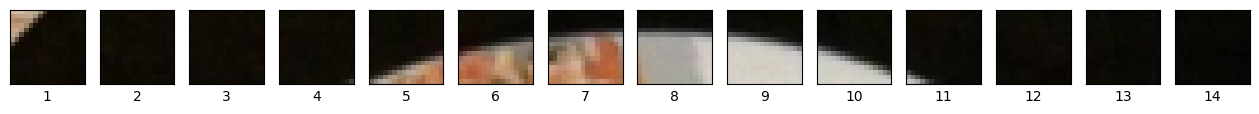

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image patch size must be divisible by patch size"
print(f"Patch Size: {patch_size} pixels x {patch_size} pixels\n")
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size//patch_size,
                        figsize = (patch_size, patch_size),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :])
  axs[i].set_xlabel(i + 1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



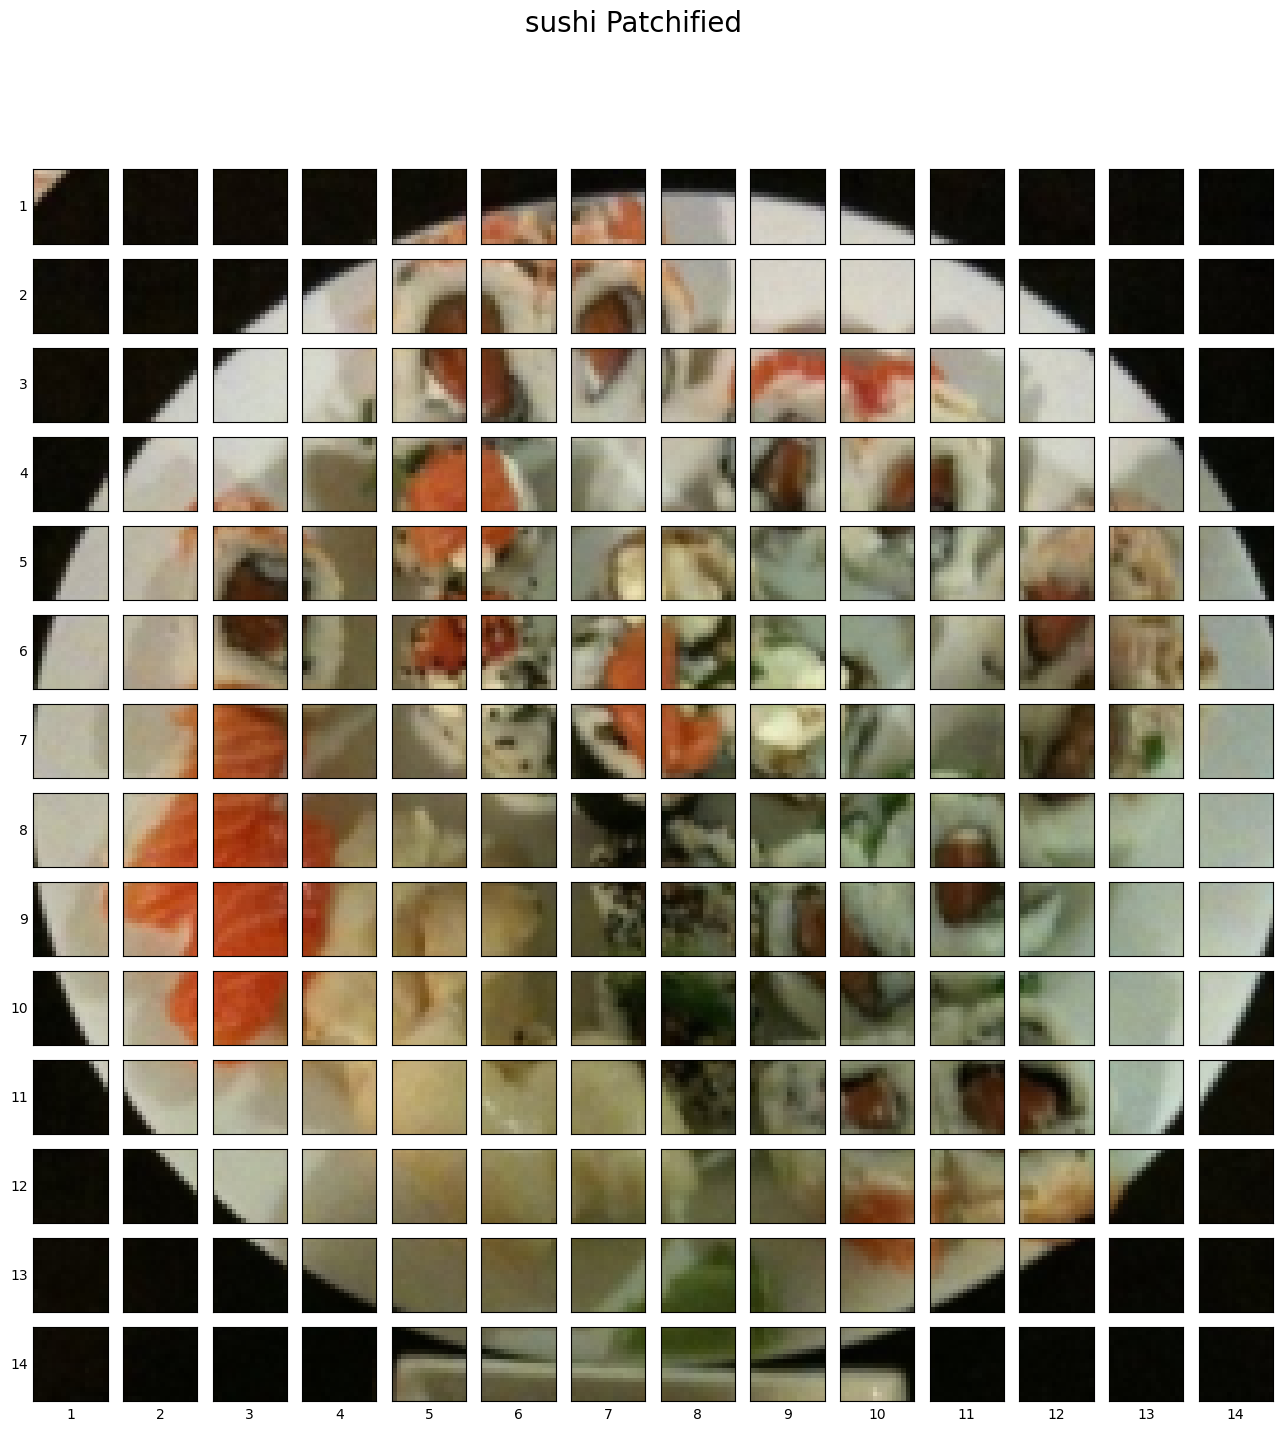

In [13]:
image_permuted = image.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows = image_height // patch_size,
                        ncols = image_width // patch_size,
                        sharex = True,
                        sharey = True,
                        figsize = (patch_size, patch_size))

for i, patch_row in enumerate(range(0, image_height, patch_size)):
  for j, patch_col in enumerate(range(0, image_width, patch_size)):
    axs[i][j].imshow(image_permuted[patch_row: patch_row + patch_size, patch_col: patch_col + patch_size, : ])
    axs[i, j].set_ylabel(i + 1,
                         rotation = 'horizontal',
                         horizontalalignment = 'right',
                         verticalalignment = 'center')
    axs[i, j].set_xlabel(j + 1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} Patchified", fontsize = 20)
plt.show()

# Create Patch Embedding Layer

In [14]:
from torch import nn
patch_size = 16
image_channels = 3

conv2d = nn.Conv2d(in_channels = image_channels,
                   out_channels = patch_size * patch_size * image_channels,
                   stride = patch_size,
                   kernel_size = patch_size,
                   padding = 0)

image_out_of_conv2d = conv2d(image.unsqueeze(0))
image_out_of_conv2d.shape


torch.Size([1, 768, 14, 14])

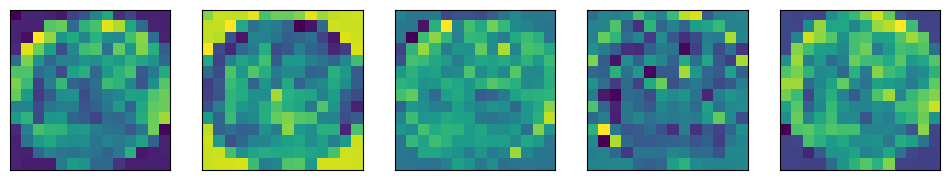

In [15]:
import random
random_indexes = random.sample(range(0, 768), k = 5)
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

for i, idx in enumerate(random_indexes):
  feature_map = image_out_of_conv2d[:, idx, :, :]
  axs[i].imshow(feature_map.squeeze().detach().numpy())
  axs[i].set(xticks = [], yticks = [], xticklabels = [], yticklabels=[])


In [16]:
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)
flattened_embedding = flatten_layer(image_out_of_conv2d)
print(f"Shape out of Flattened Layer: {flattened_embedding.shape}")
desired_embedding = flattened_embedding.permute(0, 2, 1)
print(f"Our desired embedding shape: {desired_embedding.shape}")

Shape out of Flattened Layer: torch.Size([1, 768, 196])
Our desired embedding shape: torch.Size([1, 196, 768])


In [17]:
# few constants that needed to be defined
patch_size = 16
img_size = 224
feedforward_dim = 3072
mlp_dropout = 0.1
patch_dropout = 0.1,
attn_dropout = 0
num_heads = 12
num_transformer_encoder = 12
in_channels = 3


In [18]:
# PatchEmbeddingLayer which creates our needed patches
class PatchEmbeddingLayer(nn.Module):
  def __init__(self,
               patch_size: int = 16,
               in_channels: int =3,
               embedding_dim: int = 768):
    super().__init__()
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim =3,)

  def forward(self, x):
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)


# MultiheadAttention Block of the Enocder part which calculates attention
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               num_heads: int = 12,
               attn_dropout: int = 0,
               embedding_dim: int = 768):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.msa = nn.MultiheadAttention(embed_dim = embedding_dim,
                                     num_heads = num_heads,
                                     dropout = attn_dropout,
                                     batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.msa(query = x,
                 key =x,
                 value =x,
                 need_weights = False)
    return attn_output

#MLPBlock of Encoder which extracts and utilizes value from the calculated attention
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x


class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               num_heads: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               attn_dropout: int = 0,
               mlp_dropout: float = 0.1):
    super().__init__()
    self.msa_layer = MultiHeadSelfAttentionBlock(num_heads = num_heads,
                                                 embedding_dim = embedding_dim,
                                                 attn_dropout = 0)
    self.mlp_layer = MLPBlock(embedding_dim = 768,
                              mlp_size = 3072,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_layer(x) + x
    x = self.mlp_layer(x) + x
    return x


class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int  = 768,
               embedding_dropout: float = 0.1,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               attn_dropout: int = 0,
               num_transformer_layers: int = 12,
               num_classes: int = 1000):
    super().__init__()
    assert img_size % patch_size == 0, "Image size must be divisible by patch size"
    self.num_patches = (img_size * img_size) // patch_size ** 2
    self.patch_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                           patch_size = patch_size,
                                           embedding_dim = embedding_dim)
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad = True)
    self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad = True)
    self.embedding_dropout = nn.Dropout(embedding_dropout)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout,
                                                                            attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dim),
                                    nn.Linear(in_features = embedding_dim,
                                              out_features = num_classes))


  def forward(self, x):
    batch_size = x.shape[0]
    x  = self.patch_layer(x)
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = torch.cat([class_token, x], dim = 1)
    x = x + self.position_embedding
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x



In [19]:
class_names

['pizza', 'steak', 'sushi']

In [21]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.5226, 0.1689, 0.4859]], grad_fn=<AddmmBackward0>)

In [22]:
vit

ViT(
  (patch_layer): PatchEmbeddingLayer(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_layer): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (msa): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_layer): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Tra

In [23]:
from torchinfo import summary
summary(vit,
        input_size = (32, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [32, 3]                   152,064
├─PatchEmbeddingLayer: 1-1                         [32, 196, 768]            --
│    └─Conv2d: 2-1                                 [32, 768, 14, 14]         590,592
│    └─Flatten: 2-2                                [32, 768, 196]            --
├─Dropout: 1-2                                     [32, 197, 768]            --
├─Sequential: 1-3                                  [32, 197, 768]            --
│    └─TransformerEncoderBlock: 2-3                [32, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-1       [32, 197, 768]            2,363,904
│    │    └─MLPBlock: 3-2                          [32, 197, 768]            4,723,968
│    └─TransformerEncoderBlock: 2-4                [32, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-3       [32, 197, 768]            2,363,904
│   

In [24]:
import torch
optimizer = torch.optim.Adam(vit.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1,
                             betas = (0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
results = engine.train(model= vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs =10,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2719 | train_acc: 0.4531 | test_loss: 1.4647 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4636 | train_acc: 0.3906 | test_loss: 1.3971 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4803 | train_acc: 0.2852 | test_loss: 1.3091 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5011 | train_acc: 0.4062 | test_loss: 1.5905 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.4117 | train_acc: 0.2695 | test_loss: 1.0496 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.4228 | train_acc: 0.3047 | test_loss: 1.1312 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.4057 | train_acc: 0.3320 | test_loss: 1.1116 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.7609 | train_acc: 0.2812 | test_loss: 1.5548 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1306 | train_acc: 0.4141 | test_loss: 1.3363 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2363 | train_acc: 0.4258 | test_loss: 1.0484 | test_acc: 0.5417


In [26]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768,
                                   out_features = len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 124MB/s]


In [27]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [28]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [29]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176
